In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit

import numpyro
from numpyro.diagnostics import hpdi, print_summary, summary
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, log_likelihood, NUTS, MCMC, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoNormal

Qn1: Conduct a prior predictive simulation for the Reedfrog model. By this I mean to
simulate the prior distribution of tank survival probabilities αj. Start by using this
prior:

αj ∼Normal( ̄α,σ)

 ̄α∼Normal(0,1)

σ∼Exponential(1)

Be sure to transform the αj values to the probability scale for plotting and summary.
How does increasing the width of the prior on σ change the prior distribution of αj?
You might try Exponential(10)and Exponential(0.1)for example.

In [2]:
# model 
def m1(lam):
    # priors
    a = numpyro.sample('a', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Exponential(lam) )
    numpyro.sample('alpha', dist.Normal(a, sigma))

def run_m1(lam): 
    rng_key = random.PRNGKey(101)
    kernel = NUTS(m1)
    mcmc = MCMC(kernel, num_warmup=10000, num_samples=10000, num_chains=4, chain_method='sequential')
    mcmc.run(rng_key, lam = lam)
    mcmc.print_summary()
    samples = az.from_numpyro(mcmc)
    az.plot_trace(samples)
    plt.tight_layout()
    plt.show()
    return samples

sample: 100%|██████████| 20000/20000 [00:07<00:00, 2683.40it/s, 23 steps of size 1.74e-01. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.99      0.01     -1.58      1.66   5758.17      1.00
     alpha      0.01      1.76      0.00     -2.71      2.57   7277.81      1.00
     sigma      1.07      1.00      0.77      0.07      2.39   2657.95      1.00

Number of divergences: 2401


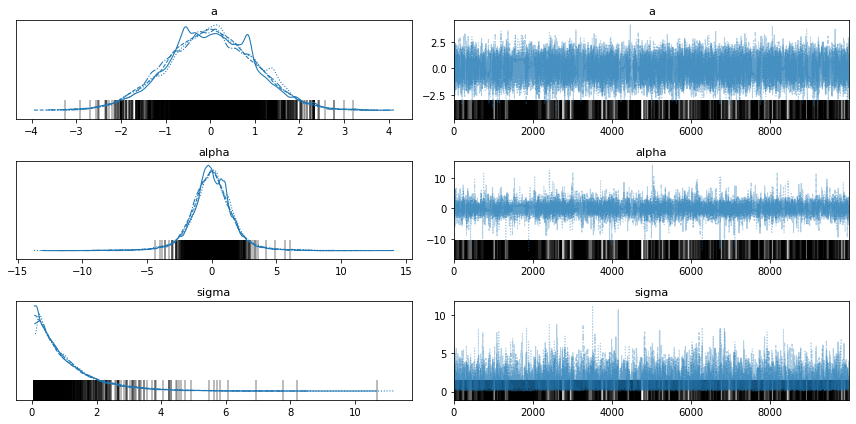

In [3]:
# lambda = 1
lam = 1
sample_1 = run_m1(lam)


sample: 100%|██████████| 20000/20000 [00:07<00:00, 2690.17it/s, 7 steps of size 3.90e-01. acc. prob=0.71] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.01      0.99     -0.02     -1.61      1.63   5561.05      1.00
     alpha      0.03     15.36     -0.11    -22.79     21.73   8445.65      1.00
     sigma     10.90     10.32      7.66      0.45     24.18   2106.41      1.00

Number of divergences: 4457


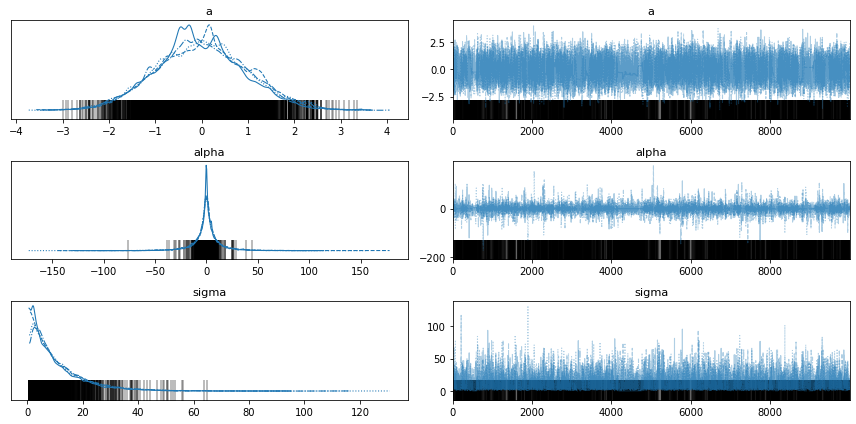

In [4]:
lam = 0.1
sample_0dot1 = run_m1(lam)

sample: 100%|██████████| 20000/20000 [00:07<00:00, 2641.84it/s, 63 steps of size 6.70e-02. acc. prob=0.27]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.91     -0.08     -1.45      1.59    116.78      1.04
     alpha      0.01      0.92     -0.09     -1.48      1.59    121.18      1.04
     sigma      0.10      0.10      0.07      0.02      0.23     47.07      1.08

Number of divergences: 9701


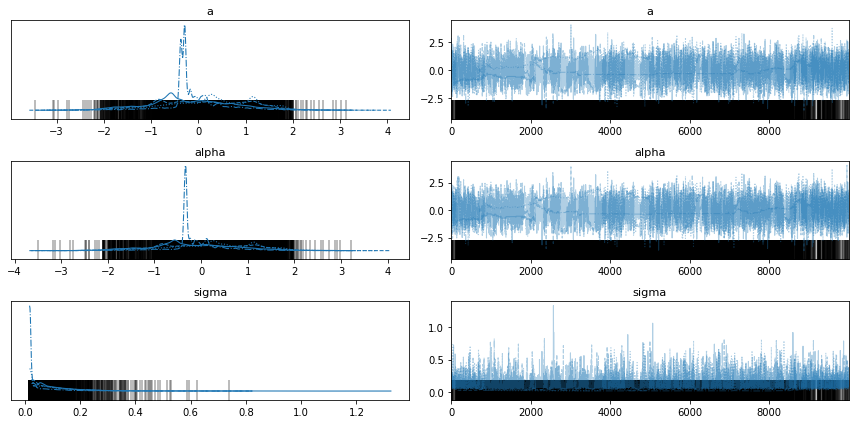

In [5]:
# lambda = 10
lam = 10
sample_10 = run_m1(lam)

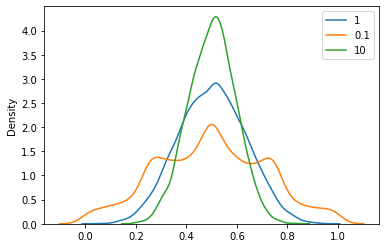

In [6]:
import seaborn as sns
sns.kdeplot(expit(sample_1.posterior.alpha.data).mean(axis=0))
sns.kdeplot(expit(sample_0dot1.posterior.alpha.data).mean(axis=0))
sns.kdeplot(expit(sample_10.posterior.alpha.data).mean(axis=0))
plt.legend(['1', '0.1','10'])
plt.show()

When sigma is wide (i.e. lambda is small), the result space is more spread 

Qn2. Revisit the Reedfrog survival data, data(reedfrogs). Start with the varying
effects model from the book and lecture. Then modify it to estimate the causal effects
of the treatment variables pred and size, including how size might modify the effect
of predation. An easy approach is to estimate an effect for each combination of pred
and size. Justify your model with a DAG of this experiment.

In [7]:
# read in the data 
rf_df=pd.read_csv('../Data/reedfrogs.csv')
rf_df.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [8]:
# add "tank"
rf_df["tank"] = rf_df.index.values
# make varibles into numbers 
rf_df["bpred"]= rf_df.pred.apply(lambda x:1 if x=='pred' else 0)
rf_df["bsize"]= rf_df['size'].apply(lambda x:1 if x=='big' else 0)
rf_df.head()

,density,pred,size,surv,propsurv,tank,bpred,bsize
0,10,no,big,9,0.9,0,0,1
1,10,no,big,10,1.0,1,0,1
2,10,no,big,7,0.7,2,0,1
3,10,no,big,10,1.0,3,0,1
4,10,no,small,9,0.9,4,0,0


In [9]:
# pred and size 
def m2(bpred, bsize, density, tank, surv=None):
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    a = numpyro.sample("a", dist.Normal(0, sigma), sample_shape=tank.shape)
    b = numpyro.sample('b', dist.Normal(0,1), sample_shape=(2,2))
    logit_p = a[tank] + b[bpred,bsize]
    numpyro.sample("surv_hat", dist.Binomial(density, logits=logit_p), obs=surv)

rng_key = random.PRNGKey(101)
kernel = NUTS(m2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, 
        bpred=rf_df.bpred.values,
        bsize=rf_df.bsize.values,
        density=rf_df.density.values,
        tank=rf_df.tank.values,
        surv=rf_df.surv.values,)

sample: 100%|██████████| 2000/2000 [00:00<00:00, 2529.61it/s, 15 steps of size 3.25e-01. acc. prob=0.90]


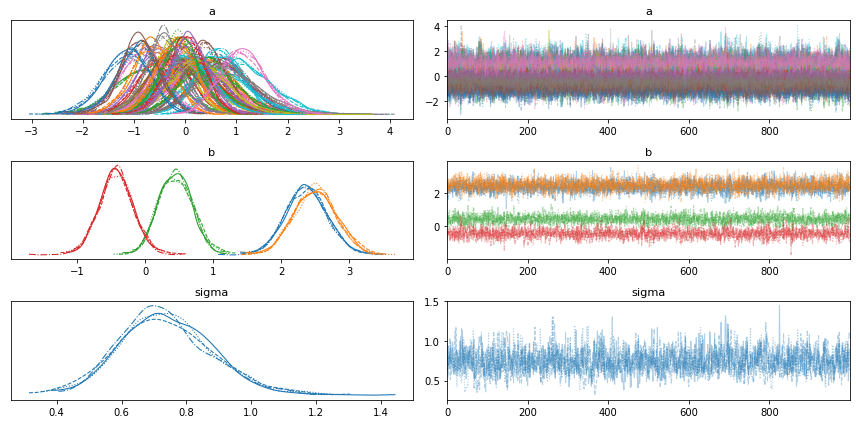

In [10]:
samples_2 = az.from_numpyro(mcmc)
az.plot_trace(samples_2)
plt.tight_layout()
plt.show()

In [11]:
posterior_2 = mcmc.get_samples()
posterior_2.pop('a')
print_summary(posterior_2, 0.89, False)
prob_pred_size= (posterior_2['b']).mean(axis=0).round(2)
print(f'impact of no pred + small size: {prob_pred_size[0][0]: .2f}')
print(f'impact of no pred + big size: {prob_pred_size[0][1]: .2f}')
print(f'impact of pred + small size: {prob_pred_size[1][0]: .2f}')
print(f'impact of pred + big size: {prob_pred_size[1][1]: .2f}')




                mean       std    median      5.5%     94.5%     n_eff     r_hat
    b[0,0]      2.37      0.31      2.37      1.91      2.89   3669.14      1.00
    b[0,1]      2.50      0.31      2.50      1.99      2.99   3793.51      1.00
    b[1,0]      0.45      0.25      0.44      0.05      0.83   2539.56      1.00
    b[1,1]     -0.43      0.25     -0.43     -0.86     -0.05   2322.00      1.00
     sigma      0.74      0.14      0.73      0.51      0.97   1254.51      1.00

impact of no pred + small size:  2.37
impact of no pred + big size:  2.50
impact of pred + small size:  0.45
impact of pred + big size: -0.43


When there's no preditors, the impact of size on survival is roughly the same. 
However, in the presence of preditors, bigger size has a negative impact on survival. 

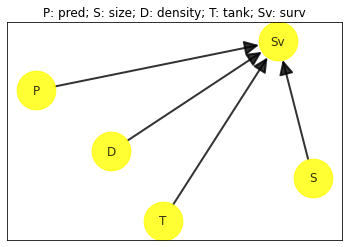

In [12]:
# draw DAG 
# bpred, bsize, density, tank, surv
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from([("P", "Sv"), ("S", "Sv"), ("D", "Sv"), 
                      ("T", "Sv")
                     ])
nx.draw_networkx(graph, arrows=True, alpha=0.8, node_color = 'yellow',
                width=2, node_size=1500, arrowsize = 30)
plt.title ("P: pred; S: size; D: density; T: tank; Sv: surv")
plt.show()

3. Now estimate the causal effect of density on survival. Consider whether pred
modifies the effect of density. There are several good ways to include density in
your Binomial GLM. You could treat it as a continuous regression variable (possi-
bly standardized). Or you could convert it to an ordered category (with three lev-
els). Compare the σ(tank standard deviation) posterior distribution to σfrom your
model in Problem 2. How are they different? Why?

In [13]:
# density as category 
rf_df['D']=pd.factorize(rf_df.density)[0]

In [14]:
# density 
def m3(bpred, bsize, density, D, tank, surv=None):
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    a = numpyro.sample("a", dist.Normal(0, sigma), sample_shape=tank.shape)
    b = numpyro.sample('b', dist.Normal(0,1), sample_shape=(2,2))
    d = numpyro.sample('d', dist.Normal(0,0.5), sample_shape=(2,3))
    logit_p = a[tank] + b[bpred,bsize] + d[bpred,D]
    #d = numpyro.sample('d', dist.Normal(0,0.5), sample_shape=(2,))
    #logit_p = a[tank] + b[bpred,bsize] + d[bpred]* D
    numpyro.sample("surv_hat", dist.Binomial(density, logits=logit_p), obs=surv)

rng_key = random.PRNGKey(101)
kernel = NUTS(m3)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, 
        bpred=rf_df.bpred.values,
        bsize=rf_df.bsize.values,
        density = rf_df.density.values,
        D=rf_df.D.values,
        tank=rf_df.tank.values,
        surv=rf_df.surv.values,)

sample: 100%|██████████| 2000/2000 [00:00<00:00, 2304.68it/s, 15 steps of size 2.34e-01. acc. prob=0.91]


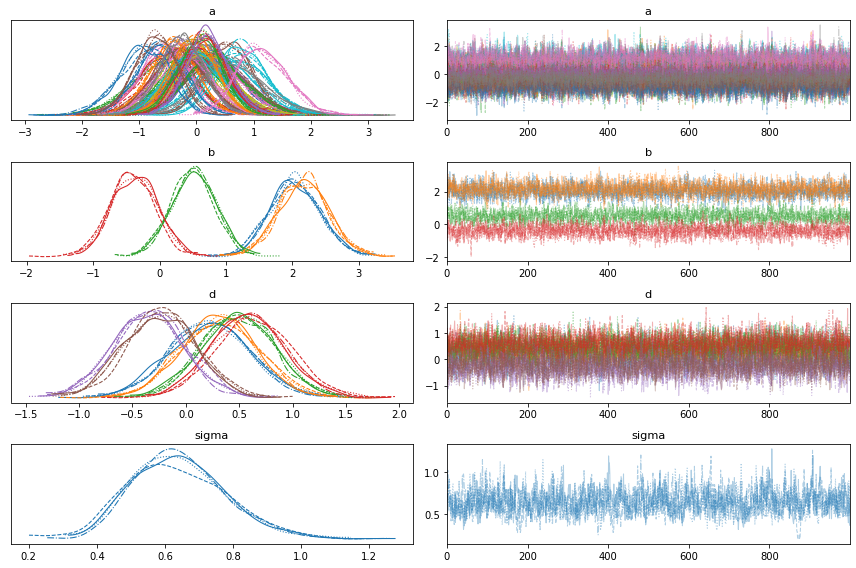

In [15]:
samples_3 = az.from_numpyro(mcmc)
az.plot_trace(samples_3)
plt.tight_layout()
plt.show()

In [16]:
posterior_3 = mcmc.get_samples()
posterior_3.pop('a')
print_summary(posterior_3, 0.89, False)
prob_pred_size= (posterior_3['b']).mean(axis=0).round(2)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
    b[0,0]      2.04      0.38      2.03      1.37      2.59   2236.78      1.00
    b[0,1]      2.17      0.38      2.18      1.55      2.76   2524.75      1.00
    b[1,0]      0.51      0.33      0.51     -0.00      1.06   1653.21      1.00
    b[1,1]     -0.38      0.34     -0.39     -0.94      0.14   1571.75      1.00
    d[0,0]      0.23      0.38      0.23     -0.38      0.83   3214.57      1.00
    d[0,1]      0.32      0.36      0.32     -0.26      0.87   2896.20      1.00
    d[0,2]      0.49      0.34      0.49     -0.06      1.03   2391.21      1.00
    d[1,0]      0.60      0.35      0.60      0.07      1.17   2208.34      1.00
    d[1,1]     -0.35      0.34     -0.35     -0.89      0.19   1628.76      1.00
    d[1,2]     -0.23      0.33     -0.23     -0.76      0.30   1898.93      1.00
     sigma      0.64      0.14      0.63      0.43      0.86    892.99      1.00



The impact of the size and pred interaction (b) hasn't changed much from qn2. 
Looking at the density and pred interaction (d), when there's no preditors, higher density has a greater positve impact on survival. However, when there's preditors, higher density has negative impact on survival. 

In [19]:
#log density 
import numpy as np
rf_df['D']=np.log(rf_df.density)

In [30]:
# density 
def m3_1(bpred, bsize, density, D, tank, surv=None):
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    a = numpyro.sample("a", dist.Normal(0, sigma), sample_shape=tank.shape)
    b = numpyro.sample('b', dist.Normal(0,1), sample_shape=(2,2))
    d = numpyro.sample('d', dist.Normal(0,0.05), sample_shape=(2,))
    logit_p = a[tank] + b[bpred,bsize] + d[bpred]* D
    numpyro.sample("surv_hat", dist.Binomial(density, logits=logit_p), obs=surv)

rng_key = random.PRNGKey(101)
kernel = NUTS(m3_1)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, 
        bpred=rf_df.bpred.values,
        bsize=rf_df.bsize.values,
        density = rf_df.density.values,
        D=rf_df.D.values,
        tank=rf_df.tank.values,
        surv=rf_df.surv.values,)

sample: 100%|██████████| 2000/2000 [00:00<00:00, 2049.91it/s, 15 steps of size 2.68e-01. acc. prob=0.91]


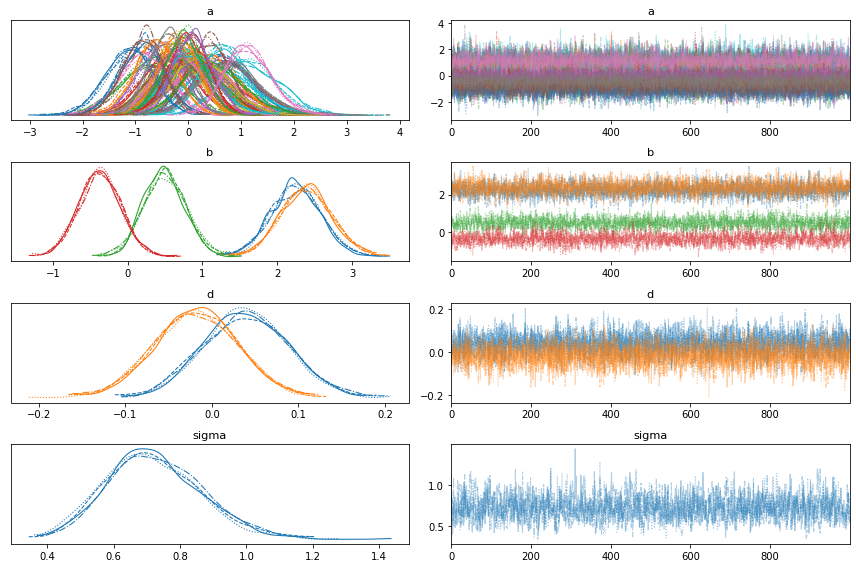

In [31]:
samples_3_1 = az.from_numpyro(mcmc)
az.plot_trace(samples_3_1)
plt.tight_layout()
plt.show()

In [32]:
posterior_3_1 = mcmc.get_samples()
posterior_3_1.pop('a')
print_summary(posterior_3_1, 0.89, False)
prob_pred_size= (posterior_3_1['b']).mean(axis=0).round(2)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
    b[0,0]      2.25      0.34      2.25      1.71      2.77   3129.26      1.00
    b[0,1]      2.39      0.34      2.39      1.83      2.92   3755.13      1.00
    b[1,0]      0.49      0.28      0.49      0.04      0.93   2352.75      1.00
    b[1,1]     -0.37      0.28     -0.37     -0.83      0.06   2227.66      1.00
      d[0]      0.04      0.05      0.04     -0.04      0.12   5563.16      1.00
      d[1]     -0.02      0.05     -0.02     -0.10      0.06   5280.19      1.00
     sigma      0.72      0.14      0.71      0.50      0.95   1240.16      1.00

